## Introduction

## Model Architecture

The model here is a multi-layer architecture consisting of alternating convolutions and nonlinearities. These layers are followed by fully connected layers leading into a sigmoid. The model follows the architecture similar to VGG16 by K. Simonyan and A. Zisserman.

Tuning

- Diagnostics
- Weight Initialization
- Learning Rate
- Activation Functions
- Network Topology
- Batches and Epochs
- Regularization
- Optimization and Loss
- Early Stopping


Using TensorFlow backend.


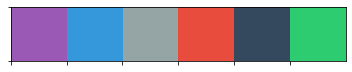

In [1]:
# Images
from PIL import Image
from skimage.io import imread
from skimage.transform import resize
import imgaug as aug
import imgaug.augmenters as imaug

# Toolbox
from pathlib import Path
import os
import numpy as np
import pandas as pd 
import seaborn as sns
import random
import sys
import matplotlib.pyplot as plt
%matplotlib inline

# Deep learning libraries
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, SeparableConv2D, MaxPool2D, LeakyReLU, ReLU, Activation
from keras.optimizers import Adam, SGD, RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import keras
import tensorflow as tf
import tensorflow.keras
import cv2

# Evaluation libraries
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score, recall_score, precision_score, roc_auc_score, f1_score, accuracy_score
from sklearn.metrics import precision_recall_curve, auc
from mlxtend.plotting import plot_confusion_matrix

# Misc
import os
import warnings
warnings.filterwarnings(action='ignore')

# Preset data display
pd.options.display.max_seq_items = 1000
pd.options.display.max_rows =1000
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_colwidth', 500)

# Set notebook colors and palette
flatui = ['#9b59b6', '#3498db', '#95a5a6', '#e74c3c', '#34495e', '#2ecc71']
sns.set_palette(flatui)
sns.palplot(sns.color_palette(flatui))
sns.set_style('white')
sns.set_color_codes(palette='deep')
# Favorite code to use: #34995e

# Setting seeds for reproducibility
seed = 100
np.random.seed(seed)
tf.set_random_seed(seed)

In [2]:
print('Environment Versions:')
print(f"OpenCV Version: {cv2.__version__}")
print(f"TensorFlow Version: {tf.__version__}")
print(f"TensorFlow Keras Version: {tf.keras.__version__}")
print()
print("TensorFlow-GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")
print(f"TensorFlow CUDA: {tf.test.is_built_with_cuda()}")
print(f"Tensorflow GPU Device Currently Activated: {tf.test.gpu_device_name()}")
print()
print(f"Python {sys.version}")

Environment Versions:
OpenCV Version: 4.0.1
TensorFlow Version: 1.13.1
TensorFlow Keras Version: 2.2.4-tf

TensorFlow-GPU is available
TensorFlow CUDA: True
Tensorflow GPU Device Currently Activated: /device:GPU:0

Python 3.6.8 |Anaconda, Inc.| (default, Feb 21 2019, 18:30:04) [MSC v.1916 64 bit (AMD64)]


## Define helper functions

Add these into a python script and import them if we are not using Jupyter.

In [3]:
def pct_bar_labels():
    '''
    Function used to label the relative frequency on top of each bars
    '''
    # Set font size
    fs=15
    
    # Set plot label and ticks
    plt.ylabel('Relative Frequency (%)', fontsize=fs)
    plt.xticks(rotation=0, fontsize=fs)
    plt.yticks([])
    
    # Set individual bar labels in proportional scale
    for x in ax1.patches:
        ax1.annotate(str(x.get_height()) + '%', 
        (x.get_x() + x.get_width()/2., x.get_height()), ha='center', va='center', xytext=(0, 7), 
        textcoords='offset points', fontsize=fs, color='black')

def freq_table(var):
    '''
    Define plot global variables
    Create a function that will populate a frequency table (%)
    Get counts per feature then get the percentage over the total counts
    '''
    global ax, ax1
    
    # Get Values and pct and combine it into a dataframe
    count_freq = var.value_counts()
    pct_freq = round(var.value_counts(normalize=True)*100, 2)
    
    # Create a dataframe
    df = pd.DataFrame({'Count': count_freq, 'Percentage': pct_freq})
    
    # Print variable name
    print('Frequency of', var.name, ':')
    display(df)
    
    # Create plot
    ax1 = pct_freq.plot.bar(title='Percentage of {}'.format(var.name), figsize=(12,8))
    ax1.title.set_size(15)
    pct_bar_labels()
    plt.show()
    
# Define a null function
def get_nulls(df):
    
    # Get null pct and counts
    null_cols = pd.DataFrame(df.isnull().sum().sort_values(ascending=False), columns=['Null Data Count'])
    null_cols_pct = pd.DataFrame(round(df.isnull().sum().sort_values(ascending=False)/len(df),2), columns=['Null Data Pct'])

    # Combine dataframes horizontally
    null_cols_df = pd.DataFrame(pd.concat([null_cols, null_cols_pct], axis=1))

    all_nulls = null_cols_df[null_cols_df['Null Data Pct']>0]

    # Print
    print('There are', len(all_nulls), 'columns with missing values.')
    return all_nulls

# Define plot_nulls function
def plot_nulls(train):
    # Get null pct and counts
    null_cols = pd.DataFrame(train.isnull().sum().sort_values(ascending=False), columns=['Null Data Count'])
    null_cols_pct = pd.DataFrame(round(train.isnull().sum().sort_values(ascending=False)/len(train),2)*100, columns=['Null Data %'])

    # Combine horizontally (axis=1) into a dataframe with column names (keys=[]) then to a data frame
    null_cols_df = pd.DataFrame(pd.concat([null_cols, null_cols_pct], axis=1))

    all_nulls = null_cols_df[null_cols_df['Null Data %']>0]

    # Create figure space
    plt.figure(figsize=(12, 8))

    # Create plot
    sns.barplot(x=all_nulls.index,
                y='Null Data %',
                data=all_nulls)

    # Set plot features
    plt.xticks(rotation='90')
    plt.xlabel('Features', fontsize=15)
    plt.ylabel('Percent of Missing Values', fontsize=15)
    plt.title('Percent of Missing Data by Features', fontsize=15)
    plt.show()

## Set directory

In [4]:
# Set directory
PATH = 'C:\\Users\\' + os.getlogin() + '\\Documents\\Programming\\DeepLearning\\07-pneumonia-radiograph-imaging\\images'
os.chdir(PATH)
os.getcwd()
os.listdir()

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'C:\\Users\\David Ly\\Documents\\Programming\\DeepLearning\\07-pneunomia-radiograph-imaging\\images'

## Get train / test / val folders

In [ ]:
# Use Path
MAIN_PATH = Path(PATH)

# Path to train directory (Fancy pathlib...no more os.path!!)
train_dir = MAIN_PATH / 'train'

# Path to validation directory
val_dir = MAIN_PATH / 'val'

# Path to test directory
test_dir = MAIN_PATH / 'test'

## Image paths

In [ ]:
# Path
train_cases_dir = train_dir / 'train'
val_cases_dir = val_dir / 'val'
test_cases_dir = test_dir / 'val'

## Train images

In [ ]:
# Normal vs. pneunomia folders
normal_cases_dir = train_dir / 'NORMAL'
pneumonia_cases_dir = train_dir / 'PNEUMONIA'

# List of all training images
normal_cases = normal_cases_dir.glob('*.jpeg')
pneumonia_cases = pneumonia_cases_dir.glob('*.jpeg')

# Create an empty list to store training data
train_data = []

# Loop through normal cases and label = 0 
for img in normal_cases:
    train_data.append((img, 0))

# Loop through pneumonia cases and label = 1
for img in pneumonia_cases:
    train_data.append((img, 1))

# Create a dataframe
train_data = pd.DataFrame(train_data, columns=['image', 'label'], index=None)

# Shuffle
train_data = train_data.sample(frac=1).reset_index(drop=True)

## Test images

In [ ]:
# Path to testing images
normal_cases_dir = test_dir / 'NORMAL'
pneumonia_cases_dir = test_dir / 'PNEUMONIA'

# List of all images for training
normal_cases = normal_cases_dir.glob('*.jpeg')
pneumonia_cases = pneumonia_cases_dir.glob('*.jpeg')

# Create empty list to store the training data
test_data = []

# Loop through normal images and label = 0
for img in normal_cases:
    test_data.append((img, 0))
    
# Loop through pneumonia images and label = 1
for img in pneumonia_cases:
    test_data.append((img, 1))
    
# Create a dataframe
test_data = pd.DataFrame(test_data, columns=['image', 'label'], index=None)

## Validation images

In [ ]:
# Path to testing images
normal_cases_dir = val_dir / 'NORMAL'
pneumonia_cases_dir = val_dir / 'PNEUMONIA'

# List of all images for training
normal_cases = normal_cases_dir.glob('*.jpeg')
pneumonia_cases = pneumonia_cases_dir.glob('*.jpeg')

# Create empty list to store the training data
val_data = []

# Loop through normal images and label = 0
for img in normal_cases:
    val_data.append((img, 0))
    
# Loop through pneumonia images and label = 1
for img in pneumonia_cases:
    val_data.append((img, 1))
    
# Create a dataframe
val_data = pd.DataFrame(val_data, columns=['image', 'label'], index=None)

## Show samples of Pneunomia vs. Normal X-ray scans

In [ ]:
# Get a few samples from each dataset
normal_samples = (train_data[train_data['label']==0]['image'].iloc[:3]).tolist()
pneumonia_samples = (train_data[train_data['label']==1]['image'].iloc[:3]).tolist()

# Combine the data together
combined_samples = normal_samples + pneumonia_samples

# Set figure space
f, ax = plt.subplots(2, 3, figsize=(30,15))

# Loop through images
for i in range(6):
    
    # Read the image
    img = imread(combined_samples[i])
    
    # Show image (interesting way to plot)
    ax[i//3, i%3].imshow(img, cmap='gray')
    ax[i//3, i%3].set_aspect('auto') # fixes alignment
    
    # Set title
    if i<3:
        ax[i//3, i%3].set_title('Normal', fontsize=15)
    else:
        ax[i//3, i%3].set_title('Pneumonia', fontsize=15)
        
plt.show()

## Explore

In [ ]:
freq_table(train_data['label'])

The label images are unbalanced by 25% so we have to decide if we need more data to train (acquire new images, image augmentations) or downsize the dataset where it's balanced.

In [ ]:
freq_table(test_data['label'])

Now the validation data is balanced compared to the training and testing data. The con of this is that the dataset for validation is really small so we have to take that into account if we want to use this dataset or not or combine it with the testing data or use other methods to generate a larger sample size.

## Generating images

Data augmentation is a technique to artificially create new training data from existing training data. This is done by applying domain-specific techniques to examples from the training data that create new and different training examples.

Keras allows for image augmentation. This is where we generate batches of image data with real time data augmentation. The data will be looped over in batches indefinitely. I also tested it out in one of my development notebooks [here](https://github.com/davidtnly/DeepLearning/blob/master/00-development/12-image-augment.ipynb).

[TensorFlow Keras ImageDataGenerator Doc](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator)

In [ ]:
# Define model parameters
EPOCHS = 50
BATCH_SIZE = 32
TARGET_SIZE = 150

In [ ]:
# Use ImageDataGenerator from Keras
train_datagen = ImageDataGenerator(
    rescale=1./255,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    vertical_flip=True,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(
    rescale=1./255,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    vertical_flip=True,
    horizontal_flip=True
)

# Create paths
train_gen_path = MAIN_PATH / 'train_gen'
test_gen_path = MAIN_PATH / 'test_gen'

# Set generation object path
train_gen = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(TARGET_SIZE, TARGET_SIZE),
    class_mode='binary',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=seed,
    save_to_dir=train_gen_path
)

test_gen = test_datagen.flow_from_directory(
    directory=test_dir,
    target_size=(TARGET_SIZE, TARGET_SIZE),
    class_mode='binary',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=seed,
    save_to_dir=test_gen_path
)

## Generate test data arrays

In [ ]:
# Create empty lists to store arrays and labels
test_data_arrays = []
test_labels = []

# Loop through the test data to create an array for each picture
for num in range(test_data.image.count()):
    for img in test_data:
        # Read the image and resize the image to (150, 150)
        img = plt.imread(test_data.iloc[num].image) # image
        img = cv2.resize(img, (TARGET_SIZE, TARGET_SIZE))
        # 3D image and scale
        img = np.dstack([img, img, img])
        img = img.astype('float32') / 255
        label = test_data.iloc[num].label # label
        
        # Append to the list
        test_data_arrays.append(img)
        test_labels.append(label)

# Convert to arrays
test_data_arrays = np.array(test_data_arrays)
test_labels = np.array(test_labels)

In [ ]:
test_labels.sum()

## Modeling

Leaky version of a Rectified Linear Unit.

It allows a small gradient when the unit is not active.

In [ ]:
# Build the neural network
def build_model():
    
    # Input layer
    inputs = Input(shape=(TARGET_SIZE, TARGET_SIZE, 3), name ='input_layer')
    
    # First convolutional block
    x = SeparableConv2D(filters=16, kernel_size=(3, 3), padding='same', name='conv1_1')(inputs)
    x = LeakyReLU(alpha=0.3)(x)
    x = SeparableConv2D(filters=16, kernel_size=(3, 3), padding='same', name='conv1_2')(x)
    x = LeakyReLU(alpha=0.3)(x)
    x = MaxPool2D(pool_size=(2, 2), name='pool1_1')(x) # max pooling operation for spatial data
    
    # Second convolutional block
    x = SeparableConv2D(filters=32, kernel_size=(3, 3), padding='same', name='conv2_1')(x)
    x = LeakyReLU(alpha=0.3)(x)    
    x = SeparableConv2D(filters=32, kernel_size=(3, 3), padding='same', name='conv2_2')(x)
    x = LeakyReLU(alpha=0.3)(x)    
    x = BatchNormalization(name='bn2_1')(x) # stabilizing the learning process; reduce internal covariate shifting
    x = MaxPool2D(pool_size=(2, 2), name='pool2_1')(x)
    
    # Third convolutional block
    x = SeparableConv2D(filters=64, kernel_size=(3, 3), padding='same', name='conv3_1')(x)
    x = LeakyReLU(alpha=0.3)(x)       
    x = SeparableConv2D(filters=64, kernel_size=(3, 3), padding='same', name='conv3_2')(x)
    x = LeakyReLU(alpha=0.3)(x)    
    x = BatchNormalization(name='bn3_1')(x) 
    x = MaxPool2D(pool_size=(2, 2), name='pool3_1')(x)   
    
    # Fourth convolutional block
    x = SeparableConv2D(filters=128, kernel_size=(3, 3), padding='same', name='conv4_1')(x)
    x = LeakyReLU(alpha=0.3)(x)     
    x = SeparableConv2D(filters=128, kernel_size=(3, 3), padding='same', name='conv4_2')(x)
    x = LeakyReLU(alpha=0.3)(x)    
    x = BatchNormalization(name='bn4_1')(x)     
    x = MaxPool2D(pool_size=(2, 2), name='pool4_1')(x)
    x = Dropout(rate=0.1, name='dropout4_1')(x) # prevent network from overfitting; probabilistically reduce the network capacity
    
    # Fifth convolutional block
    x = SeparableConv2D(filters=256, kernel_size=(3, 3), padding='same', name='conv5_1')(x)
    x = LeakyReLU(alpha=0.3)(x)       
    x = SeparableConv2D(filters=256, kernel_size=(3, 3), padding='same', name='conv5_2')(x)
    x = LeakyReLU(alpha=0.3)(x)    
    x = BatchNormalization(name='bn5_1')(x) 
    x = MaxPool2D(pool_size=(2, 2), name='pool5_1')(x)
    x = Dropout(rate=0.1, name='dropout5_1')(x) 
    
    # Fully connected block
    x = Flatten(name='flatten6_1')(x)
    x = Dropout(rate=0.3, name='dropout6_1')(x)
    x = Dense(512, name='fc6_1')(x)
    x = LeakyReLU(alpha=0.3)(x)   
    
    # Output
    output = Dense(units=1, activation='sigmoid', name='output')(x) # 1 so fewer parameters and computation are needed
    
    # Define model
    model = Model(inputs=inputs, outputs=output)
    return model

In [ ]:
model = build_model()
model.summary()

## Compile the model

The primary use case is to automatically save checkpoints during and at the end of training. This way you can use a trained model without having to retrain it, or pick-up training where you left of—in case the training process was interrupted.

In [ ]:
# Optimizer: once you know a good depth, start training your network with a lower learning rate along with decay
# Default: Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
optimizer = Adam(lr=0.001, decay=1e-08) # stochastic optimization; adam updates parameters with an individual learning rate

# Creating model and compiling
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Save weights
# checkpoint_path = '../model_2/best_weights-cp-{epoch:04d}.ckpt'
# checkpoint_dir = os.path.dirname(checkpoint_path)

checkpoint = ModelCheckpoint(
                             #filepath=checkpoint_path,
                             #period=5, # save every 5 epochs
                             filepath='best_weights_model_16.hdf5',
                             save_best_only=True,
                             save_weights_only=True)

# Callbacks - view internal states and statistics of the model during training
lr_reduce = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.3,
                              patience=2,
                              verbose=2,
                              mode='max') # reduce learning rate when a metric has stopped improving

# Stop if model is not improving
early_stop = EarlyStopping(monitor='val_loss',
                           min_delta=0.1,
                           patience=1,
                           mode='min')

## Fitting the model

In [ ]:
history = model.fit_generator(
    train_gen, 
    steps_per_epoch=train_gen.samples // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=test_gen,
    validation_steps=test_gen.samples // BATCH_SIZE,
    callbacks=[checkpoint, lr_reduce] # early_stop
)

## Plotting accuracy and loss

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
ax = ax.ravel()

for i, j in enumerate(['acc', 'loss']):
    ax[i].plot(history.history[j])
    ax[i].plot(history.history['val_' + j])
    ax[i].set_title('Model {}'.format(j))
    ax[i].set_xlabel('epochs', fontsize=12)
    ax[i].set_ylabel(j, fontsize=12)
    ax[i].legend(['train', 'val'])

## Prediction

In [ ]:
# Get prediction
prediction = model.predict(test_data_arrays)

acc = accuracy_score(test_labels, np.round(prediction))*100
cm = confusion_matrix(test_labels, np.round(prediction))

print('Acc: ', acc)
print('CM:' )
cm

## Evaluation Metrics

In [ ]:
tn = cm[1][0]
fp = cm[1][0]
fn = cm[0][1]
tp = cm[0][0]

print('========= Confusion Matrix =========')
sns.heatmap(cm, 
            annot=True,
            fmt='d',
            annot_kws={'size': 20})
plt.show()

print('\n========= Evaluation Metrics =========')
precision = tp/(tp+fp)*100
recall = tp/(tp+fn)*100
print('Accuracy: {:.3f}%'.format(acc))
print('Precision: {:.3f}%'.format(precision))
print('Recall: {:.3f}%'.format(recall))
print('F1-score: {:.3f}%'.format(2*precision*recall/(precision+recall)))

print('\n========= Training Accuracy =========')
print('Train acc: {}'.format(np.round((history.history['acc'][-1])*100, 2)))
print('FN: ', fn)
print('Total: ', tn+fp+fn+tp)